In [1]:
from profiler.core import *

## 1. Instantiate Engine
* workers : number of processes
* tol     : tolerance for differences when creating training data (set to 0 if data is completely clean)
* eps     : error bound for inverse covariance estimation (since we use conservative calculation when determining minimum sample size, we recommend to set eps <= 0.01)
* embedtxt: if set to true, differentiate b/w textual data and categorical data, and use word embedding for the former

In [2]:
pf = Profiler(workers=2, tol=0, eps=0.05, embedtxt=False)

## 2. Load Data
* name: any name you like
* src: \[FILE; DF; DB (not implemented)\]
* fpath: required if src == FILE
* df: required if src == DF
* check_param: print parameters used for data loading

In [3]:
pf.session.load_data(name='hospital_clean_sample_join_500', src=FILE, fpath='data/hospital_clean_sample_join_new_200.csv', check_param=True)

INFO:profiler.utility:[0.03971052169799805] Load Data start

INFO:profiler.data.dataset:parameters used for data loading:
 {'na_values': {'', 'NaN', 'nan', 'none', 'unknown', '?', 'None'}, 'sep': ',', 'header': 'infer', 'dropcol': None, 'dropna': False, 'encoding': 'utf-8', 'normalize': True, 'min_categories_for_embedding': 10}
INFO:profiler.data.dataset:inferred types of attributes: {
    "ProviderNumber": "numeric",
    "HospitalName": "text",
    "Address1": "text",
    "City": "text",
    "State": "categorical",
    "ZipCode": "numeric",
    "CountyName": "text",
    "PhoneNumber": "numeric",
    "HospitalType": "categorical",
    "HospitalOwner": "categorical",
    "EmergencyService": "categorical",
    "Condition": "categorical",
    "MeasureCode": "text",
    "MeasureName": "text",
    "Score": "text",
    "Sample": "text",
    "Stateavg": "text"
}
INFO:profiler.data.dataset:(possible types: numeric, categorical, text, date)
INFO:profiler.data.dataset:inferred operators of attri

### 2.1 Change Data Types of Attributes
* required input:
    * a list of attributes
    * a list of data types (must match the order of the attributes; can be CATEGORICAL, NUMERIC, TEXT, DATE)
* optional input:
    * a list of regular expression extractor

In [4]:
pf.session.change_dtypes(['ProviderNumber', 'ZipCode', 'PhoneNumber', 'State', 'EmergencyService','Score', 'Sample', 'HospitalType', 'HospitalOwner','Condition'], 
                            [CATEGORICAL, NUMERIC, CATEGORICAL, TEXT, TEXT, NUMERIC, NUMERIC, TEXT, TEXT, TEXT],
                            [None, None, None, None, None, r'(\d+)%', r'(\d+)\spatients', None, None, None])

# pf.session.change_dtypes(['ProviderNumber', 'ZipCode', 'PhoneNumber', 'State', 'EmergencyService','Score', 'Sample'], 
#                             [CATEGORICAL, NUMERIC, CATEGORICAL, TEXT, TEXT, NUMERIC, NUMERIC],
#                             [None, None, None, None, None, r'(\d+)%', r'(\d+)\spatients'])

INFO:profiler.data.dataset:updated types of ProviderNumber to 'categorical'
INFO:profiler.data.dataset:updated operators of ProviderNumber to ['equal']
INFO:profiler.data.dataset:updated types of ZipCode to 'numeric'
INFO:profiler.data.dataset:updated operators of ZipCode to ['equal']
INFO:profiler.data.dataset:updated types of PhoneNumber to 'categorical'
INFO:profiler.data.dataset:updated operators of PhoneNumber to ['equal']
INFO:profiler.data.dataset:updated types of State to 'text'
INFO:profiler.data.dataset:updated operators of State to ['equal']
INFO:profiler.data.dataset:updated types of EmergencyService to 'text'
INFO:profiler.data.dataset:updated operators of EmergencyService to ['equal']
INFO:profiler.data.dataset:updated types of Score to 'numeric'
INFO:profiler.data.dataset:updated operators of Score to ['equal']
INFO:profiler.data.dataset:updated types of Sample to 'numeric'
INFO:profiler.data.dataset:updated operators of Sample to ['equal']
INFO:profiler.data.dataset:upd

### 2.2. Load/Train Embeddings for TEXT
* path: path to saved/to-save embedding folder
* load: set to true -- load saved vec from 'path'; set to false -- train locally
* save: (only for load = False) save trained vectors to 'path'

In [5]:
#pf.session.load_embedding(save=True, path='data/hospital/', load=True)

## 3. Load Training Data
* multiplier: if set to None, will infer the minimal sample size; otherwise, it will create (# samples) * (# attributes) * (multiplier) training samples

In [6]:
pf.session.load_training_data(multiplier = None, difference=True)

INFO:profiler.utility:[0.2558445930480957] Create Training Data start

INFO:profiler.data.transformer:needs multiplier = 49 to bound the error in inv cov estimation <= 0.05000000
INFO:profiler.data.transformer:use multiplier = 49, and the bound is 0.00122873
INFO:profiler.data.transformer:Draw Pairs
100%|██████████| 17/17 [00:00<00:00, 144.83it/s]
INFO:profiler.data.transformer:Number of training samples: 10200
INFO:profiler.data.transformer:Computing Differences
INFO:profiler.data.transformer:estimated missing data probability in training data is 0.0243
INFO:profiler.utility:[0.886821985244751] Create Training Data execution time: 0.6309773921966553



## 4. Learn Structure
* sparsity: intensity of L1-regularizer in inverse covariance estimation (glasso)
* take_neg: if set to true, consider equal -> equal only

In [7]:
autoregress_matrix = pf.session.learn_structure(sparsity=0.05, infer_order=True)

INFO:profiler.utility:[0.8985385894775391] Learn Structure start

/root/anaconda3/lib/python3.6/site-packages/sklearn/covariance/graph_lasso_.py:265: ConvergenceWarning: graphical_lasso: did not converge after 500 iteration: dual gap: -2.225e-03
  % (max_iter, d_gap), ConvergenceWarning)
INFO:profiler.learner:use threshold 0.7003
INFO:profiler.utility:[3.1566991806030273] Learn Structure execution time: 2.2581605911254883



* score: 
    * "fit_error": mse for fitting y = B'X + c for each atttribute y 
    * "training_data_fd_vio_ratio": the higher the score, the more violations of FDs in the training data. (bounded: \[0,1\])

In [8]:
parent_sets = pf.session.get_dependencies(score="fit_error")

INFO:profiler.utility:[3.1678664684295654] Get Dependencies start

INFO:profiler.utility:[3.3276267051696777] Get Dependencies execution time: 0.1597602367401123



PhoneNumber -> ProviderNumber (0.009579961053655803)
PhoneNumber,ProviderNumber -> HospitalName (0.0029630904734997882)
PhoneNumber,ProviderNumber,HospitalName -> Address1 (0.0014239993489460483)
PhoneNumber,ProviderNumber,HospitalName,Address1 -> City (0.020212637725633305)
PhoneNumber,ProviderNumber,HospitalName,Address1,City -> ZipCode (0.004520483719542505)
PhoneNumber,ProviderNumber,HospitalName,Address1,City,ZipCode -> CountyName (0.023594950058177255)
PhoneNumber,ProviderNumber,HospitalName,Address1,CountyName -> HospitalOwner (0.12009031190537894)
CountyName,HospitalOwner -> State (0.11202976894835992)
CountyName,State -> EmergencyService (0.12250734203135531)
State -> Condition (0.2517040772592923)
Condition -> MeasureCode (0.11307444369357547)
Condition,MeasureCode -> MeasureName (0.011932678148441062)
MeasureCode,MeasureName -> Stateavg (0.012523922273155375)
{'Score': array([], dtype=object), 'Sample': array([], dtype=object), 'PhoneNumber': array([], dtype=object), 'Provid

In [9]:
import os, json
def read_fds(path='data/fds', f='TECHospital-hyfd'):
    all_fds = {}
    for line in open(os.path.join(path,f)):
        fd = json.loads(line)
        right = fd[u'dependant']['columnIdentifier']
        left = [l[u'columnIdentifier'] for l in fd[ u'determinant'][u'columnIdentifiers']]
        if right not in all_fds:
            all_fds[right] = set()
        all_fds[right].add(frozenset(left))
    return all_fds

In [10]:
gt = read_fds()

In [11]:
tp = 0
count = 0
for child in parent_sets:
    found = parent_sets[child]
    if len(found) == 0:
        continue
    count += 1
    match = False
    if child in gt:
        for parent in gt[child]:
            if set(parent).issubset(found):
                tp += 1
                match = True
                break
    if not match:
        print("{} -> {} is not valid".format(found, child))

print("Precision: %.4f"%(float(tp) / count))

['PhoneNumber'] -> ProviderNumber is not valid
['PhoneNumber' 'ProviderNumber'] -> HospitalName is not valid
['PhoneNumber' 'ProviderNumber' 'HospitalName'] -> Address1 is not valid
['PhoneNumber' 'ProviderNumber' 'HospitalName' 'Address1'] -> City is not valid
['PhoneNumber' 'ProviderNumber' 'HospitalName' 'Address1' 'City'] -> ZipCode is not valid
['PhoneNumber' 'ProviderNumber' 'HospitalName' 'Address1' 'City' 'ZipCode'] -> CountyName is not valid
['PhoneNumber' 'ProviderNumber' 'HospitalName' 'Address1' 'CountyName'] -> HospitalOwner is not valid
['CountyName' 'HospitalOwner'] -> State is not valid
['CountyName' 'State'] -> EmergencyService is not valid
['State'] -> Condition is not valid
['Condition'] -> MeasureCode is not valid
['Condition' 'MeasureCode'] -> MeasureName is not valid
['MeasureCode' 'MeasureName'] -> Stateavg is not valid
Precision: 0.0000


## 5. Visualization

/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


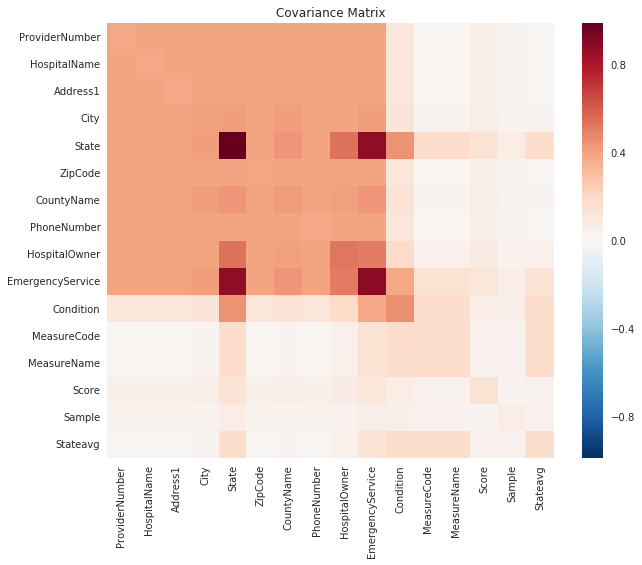

In [12]:
pf.session.visualize_covariance()

/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


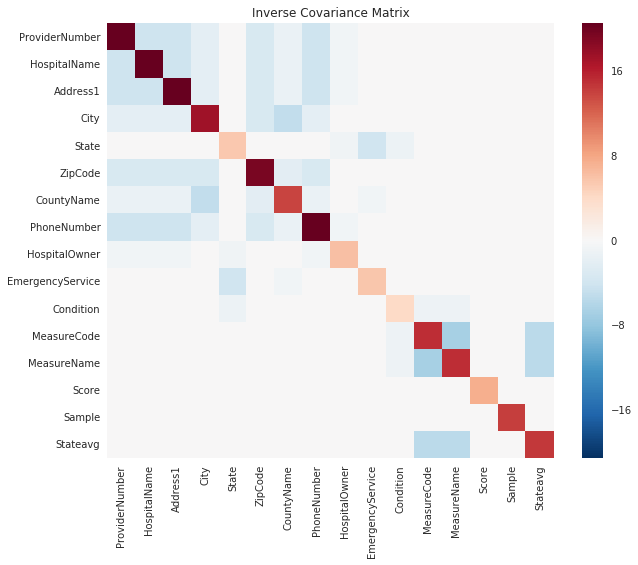

none-zero pairs of abs inv


In [13]:
pf.session.visualize_inverse_covariance()

/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


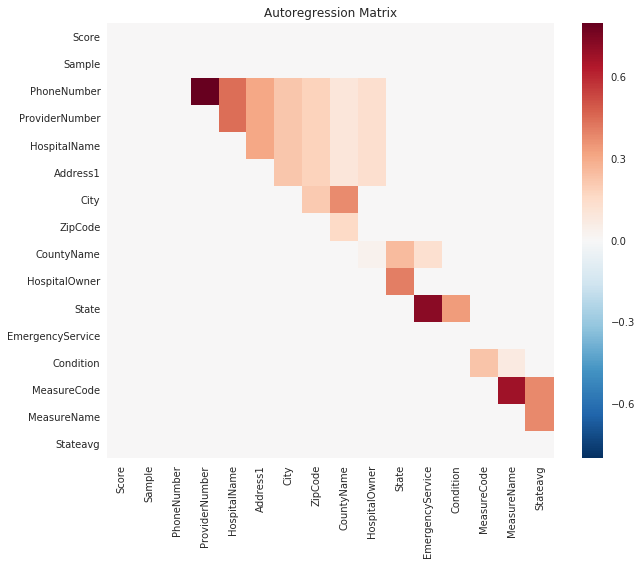

In [14]:
pf.session.visualize_autoregression()

In [15]:
pf.session.timer.get_stat()

,time_point,msg,execution_time
0,0.039711,start: Load Data,0.000000
1,0.146057,end: Load Data,0.106346
2,0.255845,start: Create Training Data,0.000000
3,0.886822,end: Create Training Data,0.630977
4,0.898539,start: Learn Structure,0.000000
5,3.156699,end: Learn Structure,2.258161
6,3.167866,start: Get Dependencies,0.000000
7,3.327627,end: Get Dependencies,0.159760
8,3.327627,total_execution_time,3.155245
